In [1]:
from typing import List, Optional
from tqdm import tqdm
import time


import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import missingno as msno
import lightgbm as lgbm
import xgboost  as xgb
import catboost as catb

import statsmodels.api as sm
import shap

from scipy.stats import gmean, rankdata

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def type_selector(df: pd.DataFrame) -> list:

    """
   
    Разбиение признаков на типы , 
    в continuous_columns передаюся непрерывные признаки с типом данных np.number,
    в categorical_columns передаются признаки с типом данных object и признаки из
    continuous_columns в которых колличество уникальных значений ниже определенного порога
    
    ---------------------------------------------------------------------------------------
    Returns
        -------
    categorical_columns: list
        список категориальных признаков
    continuous_columns: list
        список непрерывных признаков
    
    """
    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique()) < 40 # Указываем колличество уникальных значений в признаке 
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
train = pd.read_csv('./data/train.csv',index_col=0)
test = pd.read_csv('./data/test.csv',index_col=0)


In [4]:
print(F'Размерность train {train.shape[0]} наблюдений и {train.shape[1]} признак')
print(F'Размерность test {test.shape[0]} наблюдений и {test.shape[1]} признаков')

Размерность train 250000 наблюдений и 101 признак
Размерность test 150000 наблюдений и 100 признаков


In [5]:
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
id,,,,,,,,,,,,,,,,,,,,,
0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,1.09101,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,1.28138,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,1.24210,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,1.09130,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,1.10151,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


In [6]:
test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,
250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,1.11394,...,0.446389,-422.332,-1.44630,1.69075,1.059300,-3.010570,1.94664,0.529470,1.386950,8.78767
250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,1.09695,...,0.377179,10352.200,21.06270,1.84351,0.251895,4.440570,1.90309,0.248534,0.863881,11.79390
250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,1.15222,...,0.990140,3224.020,-2.25287,1.55100,-0.559157,17.838600,1.83385,0.931796,2.336870,9.05400
250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,1.20157,...,1.396880,9689.760,14.77150,1.41390,0.329272,0.802437,2.23251,0.893348,1.359470,4.84833
250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,1.16807,...,0.862502,2693.350,44.18050,1.58020,-0.191021,26.253000,2.68238,0.361923,1.532800,3.70660


In [7]:
train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.511213,51.378476,0.107155,0.050010,3595.133426,8.205953,164.508753,0.375533,16.669745,1.190382,...,4856.812768,22.579100,2.030554,0.079692,1.555097,2.417556,0.537484,1.576900,8.048805,6.813920
std,0.307884,42.396636,1.322200,0.792368,6072.401061,5.475723,183.335563,0.813597,99.758709,0.099700,...,8501.609009,14.849390,0.900211,0.587780,9.253785,0.892563,0.226589,0.646306,5.647368,7.940179
min,-0.069273,-17.000000,-7.895580,-1.475560,-7589.280000,-3.291050,-40.967200,-4.143080,-502.813000,0.934037,...,-12695.700000,-4.059170,0.057800,-1.998800,-24.686300,-1.131980,0.005249,-0.646967,-0.842397,0.000000
25%,0.251287,18.000000,-0.611172,-0.719418,163.864750,4.110127,27.894900,-0.026245,-17.392025,1.132640,...,73.203100,11.525450,1.471650,-0.408975,-4.004925,1.906718,0.359646,1.215810,3.732800,1.000000
50%,0.514962,41.000000,0.253815,0.004099,943.000500,7.472445,91.005250,0.619862,8.714945,1.170370,...,1060.025000,19.993200,1.660830,0.215710,0.759942,2.340430,0.531348,1.451285,7.182205,4.000000
75%,0.777322,75.000000,0.759249,0.765456,4115.355000,11.030950,240.843750,0.933855,55.407625,1.218880,...,5572.982500,32.271625,2.320085,0.503134,6.202503,2.910020,0.709807,1.901632,10.998550,10.000000
max,1.072070,273.000000,9.768590,1.680190,37847.500000,35.078000,947.143000,4.010380,465.956000,1.712450,...,54334.600000,79.912400,5.403020,1.944190,42.890400,5.576040,1.105400,4.492620,34.019200,42.000000


In [8]:
test.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.513137,51.612380,0.108166,0.047793,3567.849290,8.189529,163.303236,0.379849,16.626872,1.190402,...,0.582965,4858.089360,22.590537,2.028026,0.079295,1.565588,2.422223,0.537009,1.575402,8.045628
std,0.307512,42.662212,1.338636,0.790894,6045.626929,5.443633,181.799298,0.812515,99.813298,0.099975,...,0.445033,8497.126809,14.838069,0.898257,0.590101,9.268188,0.894294,0.226024,0.645402,5.642812
min,-0.064172,-17.000000,-7.952920,-1.491030,-7801.580000,-3.097580,-39.020100,-4.062280,-496.326000,0.929603,...,-0.466885,-12183.200000,-4.134800,0.120638,-2.013430,-24.337800,-1.056300,0.010615,-0.673333,-0.762355
25%,0.254897,18.000000,-0.615063,-0.718730,161.797000,4.129198,27.774750,-0.024041,-17.780300,1.132580,...,0.282301,73.567275,11.585500,1.470310,-0.408236,-4.015442,1.910508,0.359924,1.216300,3.719902
50%,0.516855,41.000000,0.253162,0.003786,935.088500,7.467945,90.090350,0.622288,8.433805,1.170310,...,0.483258,1054.480000,19.939150,1.660235,0.215228,0.811492,2.341185,0.530720,1.449735,7.191640
75%,0.778300,76.000000,0.759430,0.761793,4076.672500,11.016600,239.953000,0.936772,55.053075,1.219200,...,0.770184,5613.215000,32.208850,2.308523,0.502962,6.218857,2.918890,0.708449,1.895472,11.018700
max,1.072210,270.000000,9.931070,1.670420,38434.400000,34.533000,943.297000,4.183330,466.535000,1.711020,...,3.347080,54417.900000,80.209000,5.421360,1.920450,42.504100,5.583770,1.102790,4.472940,33.686300


In [9]:
features = train.drop('loss',axis=1).columns.to_list()
len(features)

100

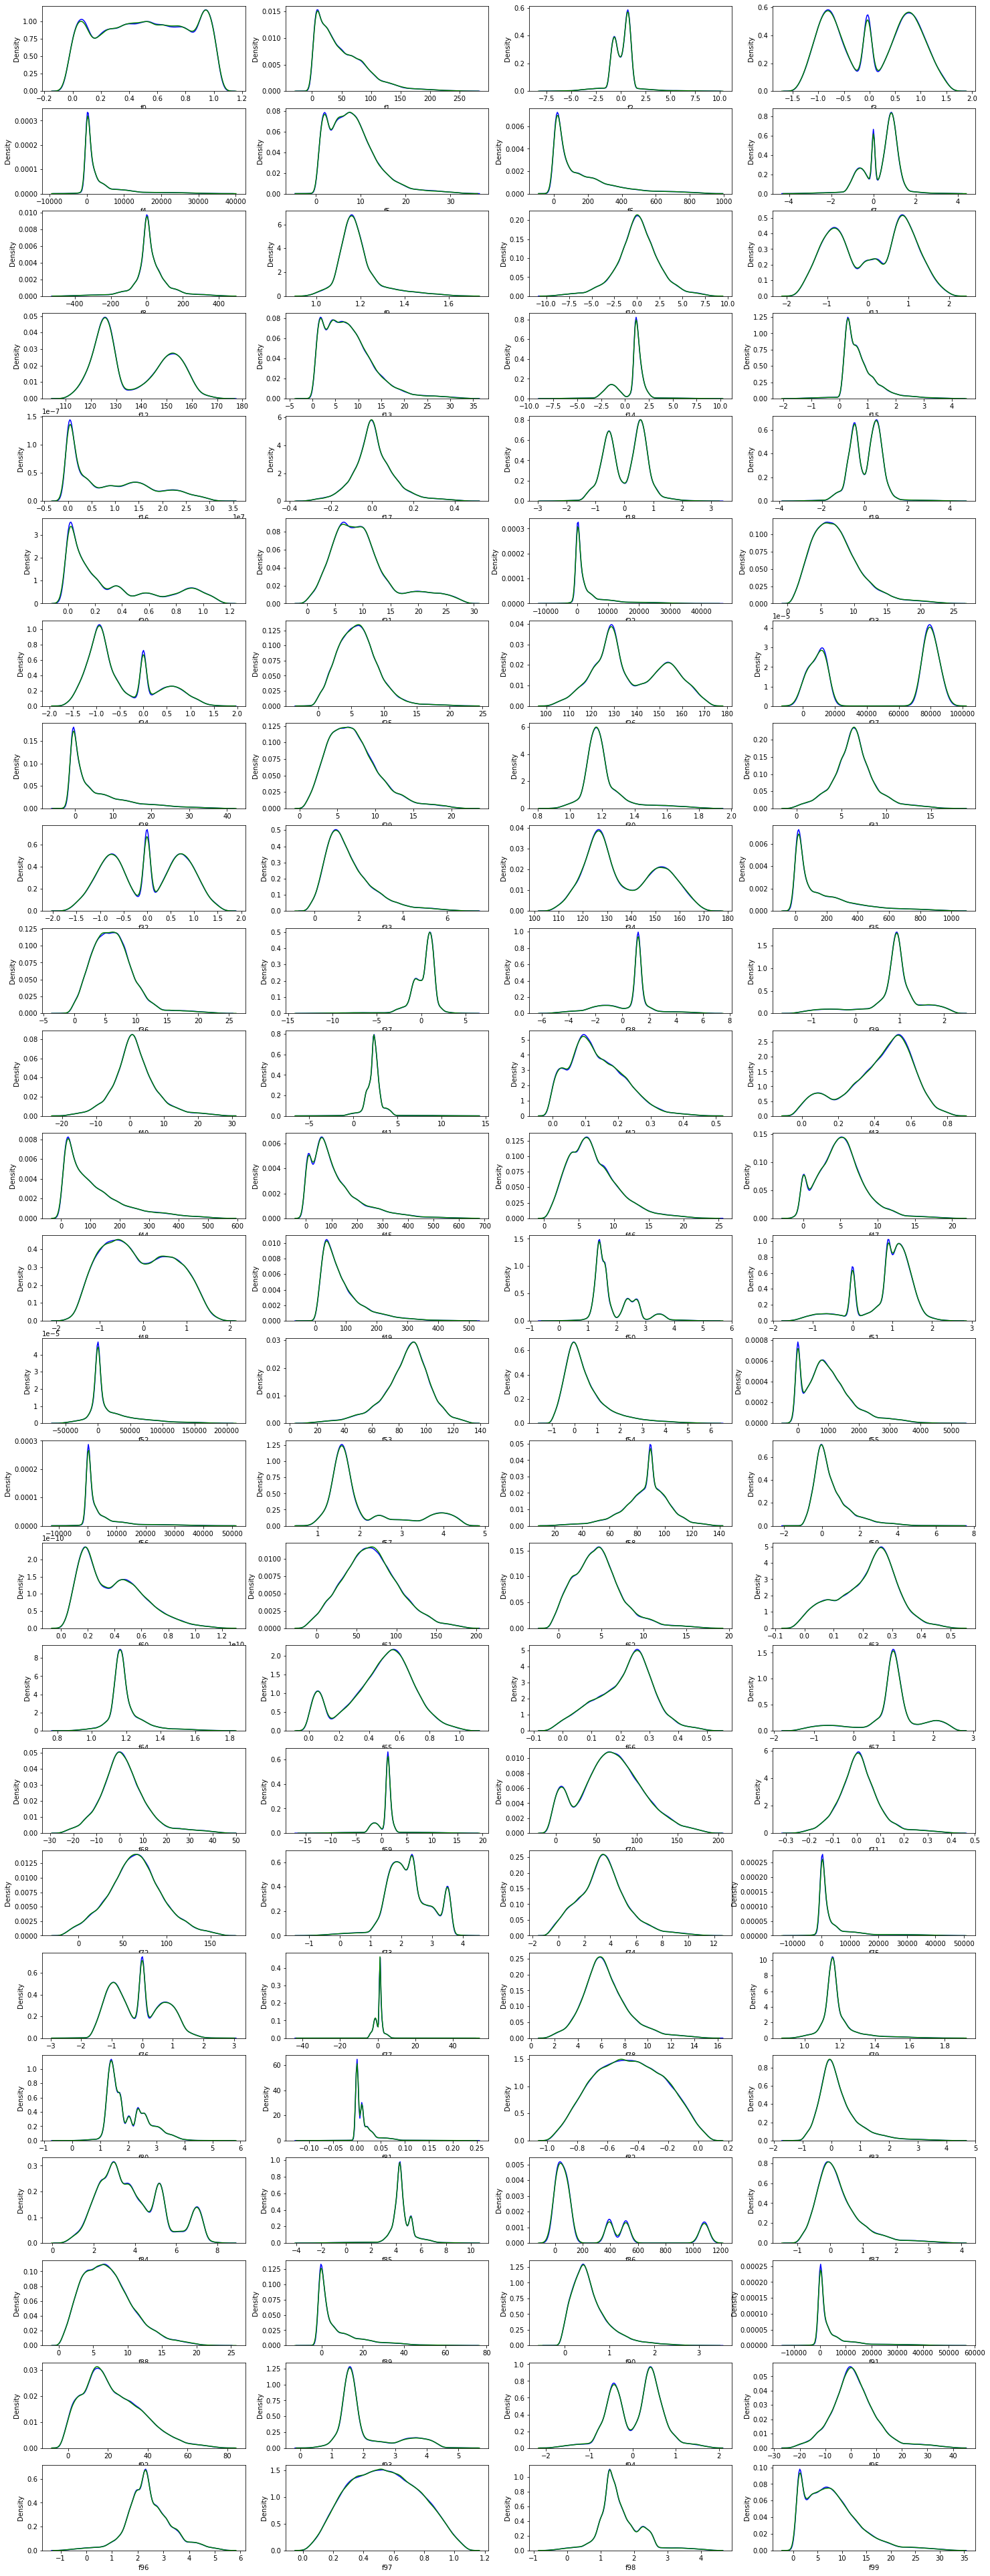

In [10]:
fig, axes = plt.subplots(25, 4, figsize=(25, 70))

for num, feature in enumerate(features):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")

<AxesSubplot:>

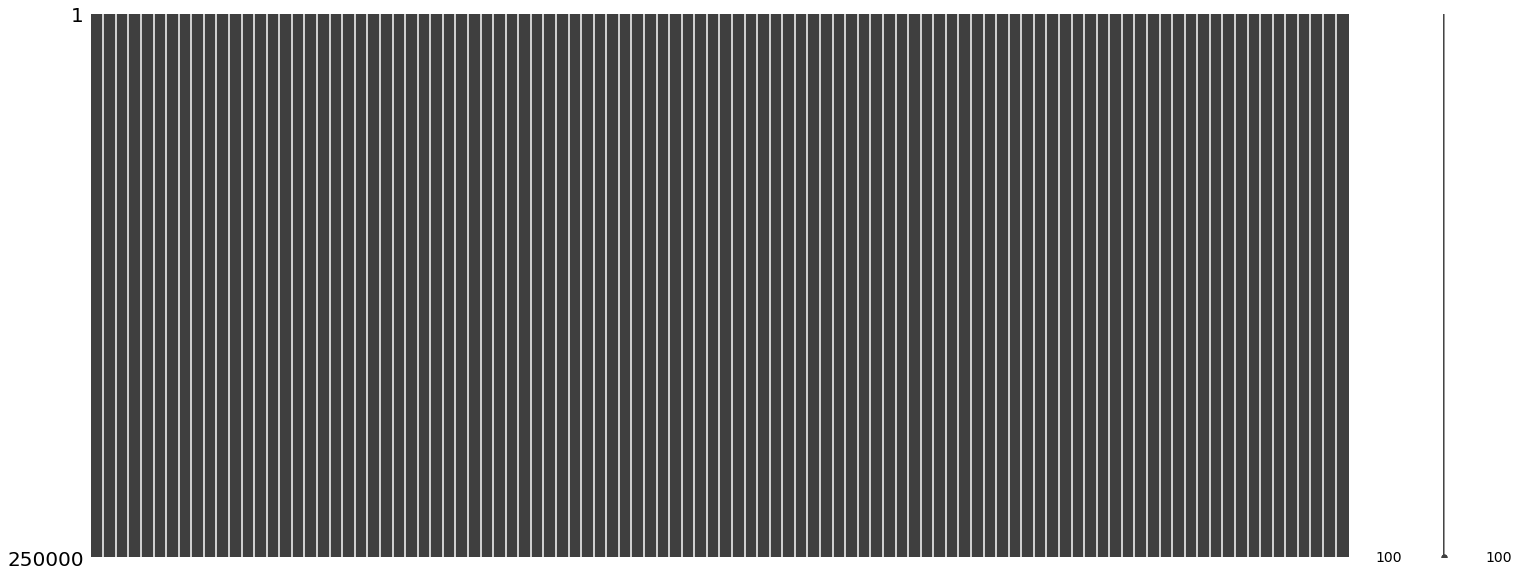

In [11]:
msno.matrix(train.drop(['loss'],1))

<AxesSubplot:>

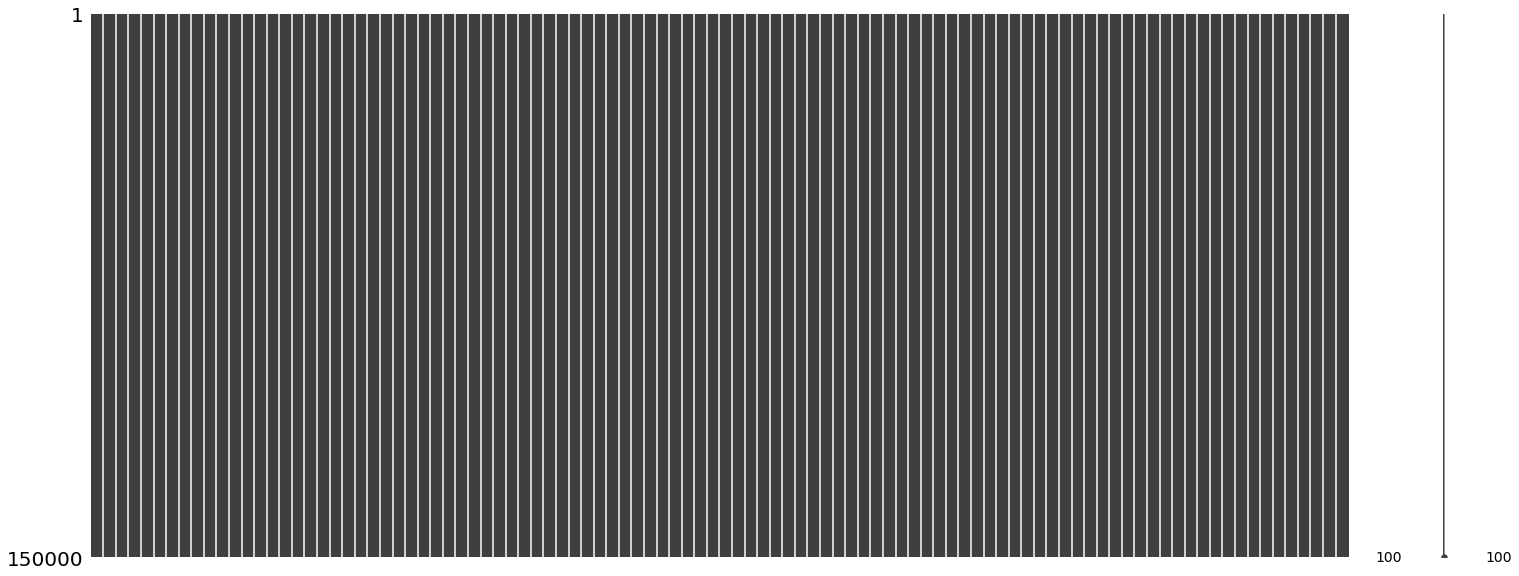

In [12]:
msno.matrix(test)

In [13]:
correlation = train.corr()
corr_with_target = correlation["loss"].sort_values(ascending = False)
corr_with_target.head()

loss    1.000000
f13     0.025730
f46     0.023828
f28     0.022780
f74     0.021610
Name: loss, dtype: float64

In [14]:
corr_with_target.tail()

f96   -0.020655
f66   -0.022424
f58   -0.023370
f52   -0.026566
f25   -0.030164
Name: loss, dtype: float64

Text(0, 0.5, 'Density')

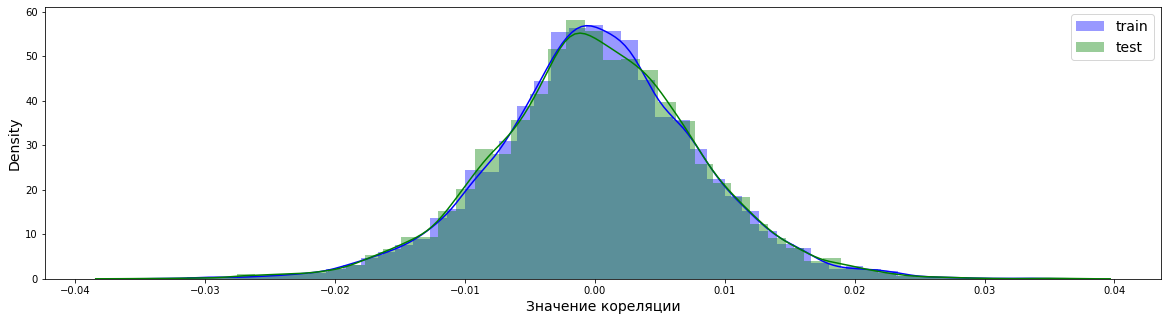

In [15]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = train.drop(['loss'],1).columns.tolist()


test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Значение кореляции", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

<AxesSubplot:title={'center':'Correlation of Numeric Features with target'}>

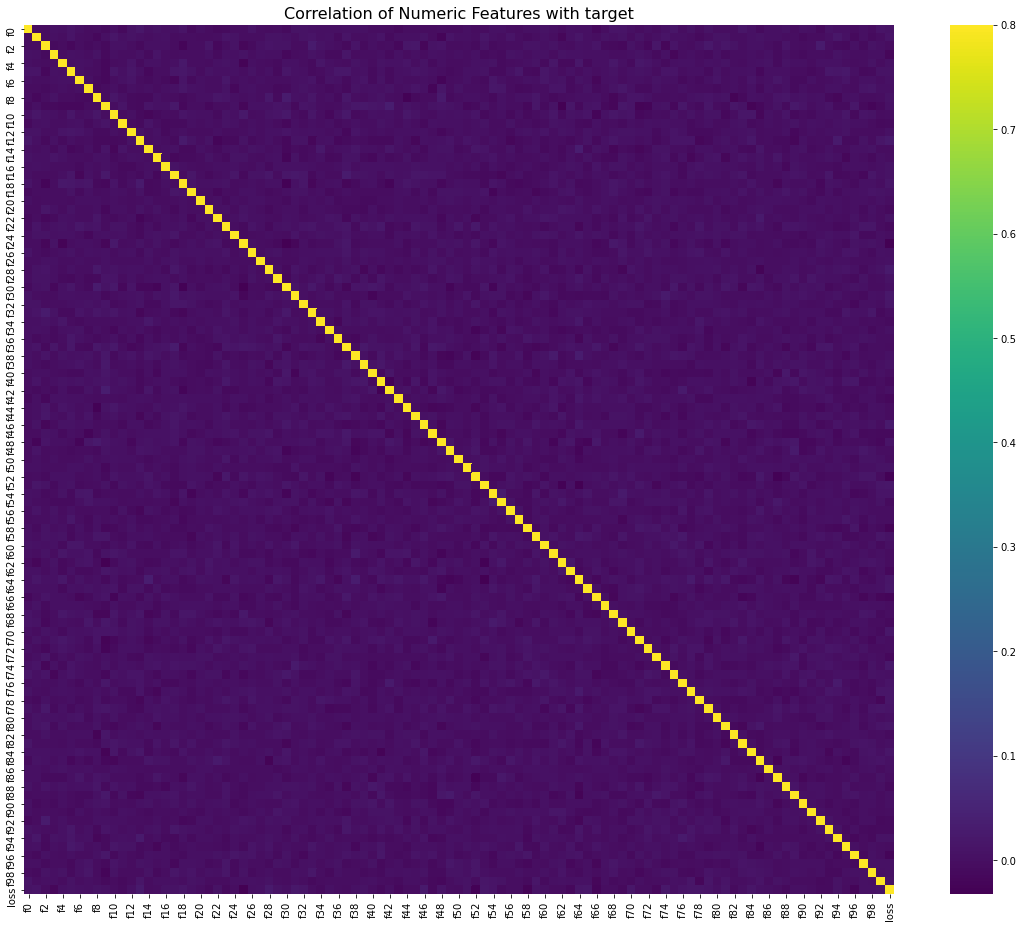

In [16]:
fig, axes = plt.subplots(figsize = (20,16))
plt.title("Correlation of Numeric Features with target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [17]:
X_adv = pd.concat([
train[features], test[features]
                        ])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

parameters = {
    "n_estimators": 22, "random_state": 27,"objective": "binary", "n_jobs": -1 }
model = lgbm.LGBMClassifier(**parameters)
    
model.fit(X_adv, y_adv)
    
cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
    )

print(f"CV-score: {round(np.mean(cv), 4)}")
print(f"Колличество оставшихся признаков {len(features)}")

importance = pd.DataFrame({
        "feature": X_adv.columns,
        "adversarial_importance": model.feature_importances_
                                })
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=100)
    
    

CV-score: 0.4995
Колличество оставшихся признаков 100


In [18]:
def freq_encoder(df: pd.DataFrame, features_list: list) -> pd.DataFrame:
    
    """
    Генерация новых признаков на основе частоты появления значений в признаке
    df(pd.DataFrame) DataFrame c данными
    features_list(list) список признаков по которым генерироватся признаки
    
    --------------------------------------------------------------------------
    
    Return
        ---------
    pd.DataFrame с признаками на основе частот
    
    """
    
    for item in features_list:
        freq_encoder = df[item].value_counts(normalize=True)
        df[item+"_freq_enc"] = df[item].map(freq_encoder)
    
    return df

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['loss'], axis=1) , 
                                                   train['loss'], random_state=50)

In [21]:
params_lgbm = {"boosting_type": "gbdt",
                  "metric": "r2",
                  "num_boost_round": 20000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.05,
                  #"class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 60,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 3,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [22]:
model = lgbm.LGBMRegressor(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_metric ="rmse" ,eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] num_iterations is set=20000, num_boost_round=20000 will be ignored. Current value: num_iterations=20000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 7.86298	valid_1's rmse: 7.86883
[400]	training's rmse: 7.82087	valid_1's rmse: 7.85108
[600]	training's rmse: 7.79069	valid_1's rmse: 7.84223
[800]	training's rmse: 7.76565	valid_1's rmse: 7.83842
[1000]	training's rmse: 7.74435	valid_1's rmse: 7.83551
[1200]	training's rmse: 7.72426	valid_1's rmse: 7.83415
Early stopping, best iteration is:
[1322]	training's rmse: 7.71321	valid_1's rmse: 7.83343


LGBMRegressor(colsample_bytree=0.5157071025553219, early_stopping_rounds=50,
              learning_rate=0.05, max_depth=3, metric='r2',
              min_child_samples=468, min_child_weight=100.0, n_estimators=5000,
              num_boost_round=20000, num_leaves=60, reg_alpha=2, reg_lambda=50,
              seed=27, subsample=0.7252600946741159)

In [23]:
pred = pd.DataFrame()
pred['loss'] = model.predict(test)

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

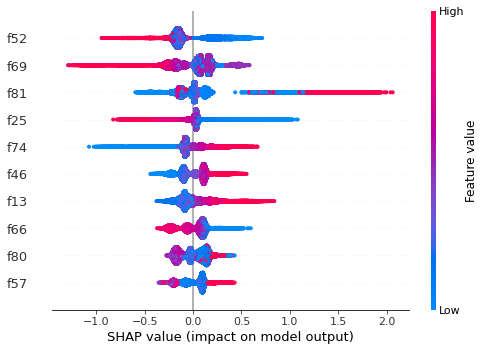

In [25]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

In [26]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']
feature_importance

,col_name,feature_importance_vals
52,f52,0.226444
69,f69,0.170214
81,f81,0.145210
25,f25,0.138346
74,f74,0.128647
...,...,...
35,f35,0.012733
15,f15,0.012100
56,f56,0.008939
62,f62,0.008428


In [27]:
feature_importance = feature_importance['col_name'].tolist()

In [28]:
train_freq_encoder = freq_encoder(train[feature_importance], feature_importance)
test_freq_encoder = freq_encoder(test[feature_importance], feature_importance)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_freq_encoder, 
                                                   train['loss'], random_state=50)

In [30]:
params_lgbm = {"boosting_type": "gbdt",
                  "metric": "r2",
                  "num_boost_round": 20000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.03,
                  #"class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 60,
                  'reg_alpha': 0.2,
                  'reg_lambda': 0.3,
                  'subsample': 0.7252600946741159,
                  "max_depth": 5,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [31]:
model = lgbm.LGBMRegressor(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_metric ="rmse" ,eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] num_iterations is set=20000, num_boost_round=20000 will be ignored. Current value: num_iterations=20000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 7.82933	valid_1's rmse: 7.86599
[400]	training's rmse: 7.75917	valid_1's rmse: 7.84694
[600]	training's rmse: 7.70395	valid_1's rmse: 7.83951
[800]	training's rmse: 7.65796	valid_1's rmse: 7.83553
[1000]	training's rmse: 7.61408	valid_1's rmse: 7.83336
Early stopping, best iteration is:
[1038]	training's rmse: 7.60581	valid_1's rmse: 7.83276


LGBMRegressor(colsample_bytree=0.5157071025553219, early_stopping_rounds=50,
              learning_rate=0.03, max_depth=5, metric='r2',
              min_child_samples=468, min_child_weight=100.0, n_estimators=5000,
              num_boost_round=20000, num_leaves=60, reg_alpha=0.2,
              reg_lambda=0.3, seed=27, subsample=0.7252600946741159)

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

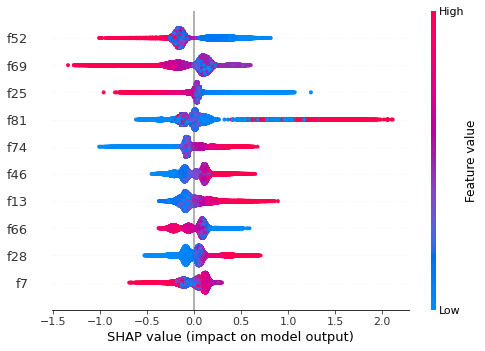

In [33]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

In [34]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']
feature_importance

,col_name,feature_importance_vals
0,f52,0.226676
1,f69,0.166540
3,f25,0.136147
2,f81,0.136055
4,f74,0.126415
...,...,...
187,f87_freq_enc,0.000155
182,f59_freq_enc,0.000000
181,f68_freq_enc,0.000000
143,f20_freq_enc,0.000000


In [35]:
feature_importance = feature_importance.loc[feature_importance['feature_importance_vals'] > 0]

In [36]:
feature_importance = feature_importance['col_name'].tolist()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(train_freq_encoder[feature_importance], 
                                                   train['loss'], random_state=50)

In [38]:
params_lgbm = {"boosting_type": "gbdt",
                  "metric": "r2",
                  "num_boost_round": 20000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.03,
                  #"class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 60,
                  'reg_alpha': 0.2,
                  'reg_lambda': 0.3,
                  'subsample': 0.7252600946741159,
                  "max_depth": 4,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [39]:
model = lgbm.LGBMRegressor(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_metric ="rmse" ,eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] num_iterations is set=20000, num_boost_round=20000 will be ignored. Current value: num_iterations=20000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 7.86009	valid_1's rmse: 7.87283
[400]	training's rmse: 7.80949	valid_1's rmse: 7.85385
[600]	training's rmse: 7.77302	valid_1's rmse: 7.84449
[800]	training's rmse: 7.74099	valid_1's rmse: 7.83899
[1000]	training's rmse: 7.71253	valid_1's rmse: 7.83542
[1200]	training's rmse: 7.68658	valid_1's rmse: 7.83324
[1400]	training's rmse: 7.66185	valid_1's rmse: 7.83225
Early stopping, best iteration is:
[1490]	training's rmse: 7.65063	valid_1's rmse: 7.83177


LGBMRegressor(colsample_bytree=0.5157071025553219, early_stopping_rounds=50,
              learning_rate=0.03, max_depth=4, metric='r2',
              min_child_samples=468, min_child_weight=100.0, n_estimators=5000,
              num_boost_round=20000, num_leaves=60, reg_alpha=0.2,
              reg_lambda=0.3, seed=27, subsample=0.7252600946741159)

In [40]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


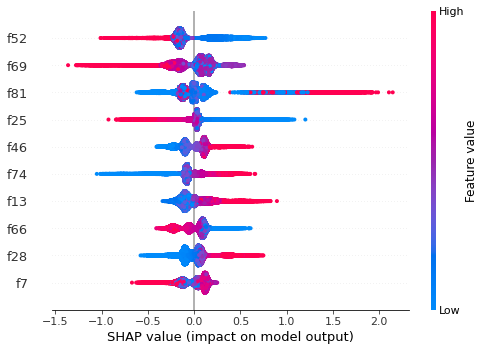

In [41]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

In [42]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']
feature_importance

,col_name,feature_importance_vals
0,f52,0.226285
1,f69,0.164406
3,f81,0.141266
2,f25,0.139155
5,f46,0.125786
...,...,...
187,f18_freq_enc,0.000000
174,f95_freq_enc,0.000000
190,f91_freq_enc,0.000000
191,f89_freq_enc,0.000000


In [43]:
feature_importance = feature_importance.loc[feature_importance['feature_importance_vals'] > 0]

In [44]:
feature_importance = feature_importance['col_name'].tolist()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_freq_encoder[feature_importance], 
                                                   train['loss'], random_state=50)

In [46]:
params_lgbm = {"boosting_type": "gbdt",
                  "metric": "r2",
                  "num_boost_round": 20000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.03,
                  #"class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 60,
                  'reg_alpha': 0.2,
                  'reg_lambda': 0.3,
                  'subsample': 0.7252600946741159,
                  "max_depth": 4,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [47]:
model = lgbm.LGBMRegressor(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_metric ="rmse" ,eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] num_iterations is set=20000, num_boost_round=20000 will be ignored. Current value: num_iterations=20000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 7.86036	valid_1's rmse: 7.87287
[400]	training's rmse: 7.80988	valid_1's rmse: 7.85399
[600]	training's rmse: 7.77223	valid_1's rmse: 7.8448
[800]	training's rmse: 7.74046	valid_1's rmse: 7.8394
[1000]	training's rmse: 7.71262	valid_1's rmse: 7.8356
[1200]	training's rmse: 7.68631	valid_1's rmse: 7.83397
[1400]	training's rmse: 7.66246	valid_1's rmse: 7.83259
[1600]	training's rmse: 7.63853	valid_1's rmse: 7.83164
Early stopping, best iteration is:
[1647]	training's rmse: 7.6327	valid_1's rmse: 7.83135


LGBMRegressor(colsample_bytree=0.5157071025553219, early_stopping_rounds=50,
              learning_rate=0.03, max_depth=4, metric='r2',
              min_child_samples=468, min_child_weight=100.0, n_estimators=5000,
              num_boost_round=20000, num_leaves=60, reg_alpha=0.2,
              reg_lambda=0.3, seed=27, subsample=0.7252600946741159)

In [48]:
pred = pd.DataFrame()
pred['loss'] = model.predict(test_freq_encoder[feature_importance])

In [49]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgbm.LGBMRegressor(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="rmse", verbose=2000, early_stopping_rounds=100,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict(x_valid)
        score = r2_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

def xgboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            #maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=100,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=20,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = r2_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        #print(f"Score mean: {folds_scores.mean()}")
        estimators.append(model)

    return estimators, encoders, oof_preds


def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = catb.Pool(x_train, y_train)
        dvalid = catb.Pool(x_valid, y_valid)

        model = catb.CatBoostRegressor(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=200, early_stopping_rounds=200
            #categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict(x_valid)
        score = r2_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    #print(f"Score mean: {folds_scores.mean()}")
    print("="*65)
    return estimators, oof_preds

    return estimators, encoders, oof_preds

In [50]:
train_scaled = scaler.fit_transform(train_freq_encoder[feature_importance])

In [51]:
test_scaled = scaler.transform(test_freq_encoder[feature_importance])

In [77]:
cv = KFold(n_splits=6, random_state=42, shuffle=True)
target, data = train['loss'], train_freq_encoder[feature_importance]

In [78]:
estimators_lgbm_target_1, oof_preds_lgbm_target_1 = lightgbm_cross_validation(
    params_lgbm, data, target, cv
)

Tue Aug 10 20:04:49 2021, Cross-Validation, 250000 rows, 190 cols
[LightGBM] [Warning] num_iterations is set=20000, num_boost_round=20000 will be ignored. Current value: num_iterations=20000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1606]	valid_0's rmse: 7.82675
Fold 1, Valid score = 0.02495
[LightGBM] [Warning] num_iterations is set=20000, num_boost_round=20000 will be ignored. Current value: num_iterations=20000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1372]	valid_0's rmse: 7.86016
Fold 2, Valid score = 0.0221
[LightGBM] [Warning] num_iterations is set=20000, num_boost_round=20000 will be ignored. Current value:

In [79]:
xgb_params = {
    "booster": "gbtree", 
    'subsample': 1, 
    #"eval_metric": "squaredlogerror", 
    "learning_rate": 0.05,  
    'reg_lambda': 18, 
    #"max_depth": 5, 
    #'reg_alpha': 40 ,
    #'min_child_weight': 16,
    "nthread": -1, 
    "seed": 27}

xgb_cv = KFold(n_splits=6, random_state=42, shuffle=True)

In [80]:
xgb_estimators_target_1, _, xgb_oof_target_1 = xgboost_cross_validation(
    xgb_params, data, target, xgb_cv)

Tue Aug 10 20:06:40 2021, Cross-Validation, 250000 rows, 190 cols
[0]	train-rmse:9.95741	valid-rmse:9.90623
[20]	train-rmse:8.18852	valid-rmse:8.17484
[40]	train-rmse:7.90175	valid-rmse:7.92182
[60]	train-rmse:7.83406	valid-rmse:7.88335
[80]	train-rmse:7.79685	valid-rmse:7.87258
[100]	train-rmse:7.76518	valid-rmse:7.86563
[120]	train-rmse:7.73579	valid-rmse:7.86061
[140]	train-rmse:7.71029	valid-rmse:7.85646
[160]	train-rmse:7.68516	valid-rmse:7.85294
[180]	train-rmse:7.66097	valid-rmse:7.84964
[200]	train-rmse:7.63887	valid-rmse:7.84671
[220]	train-rmse:7.61993	valid-rmse:7.84476
[240]	train-rmse:7.60084	valid-rmse:7.84293
[260]	train-rmse:7.58322	valid-rmse:7.84137
[280]	train-rmse:7.56482	valid-rmse:7.84026
[300]	train-rmse:7.54866	valid-rmse:7.83906
[320]	train-rmse:7.53148	valid-rmse:7.83824
[340]	train-rmse:7.51485	valid-rmse:7.83814
[360]	train-rmse:7.50091	valid-rmse:7.83748
[380]	train-rmse:7.48633	valid-rmse:7.83687
[400]	train-rmse:7.47086	valid-rmse:7.83698
[420]	train-rmse

In [81]:
params_catb = {
    "n_estimators": 10000,
    "loss_function": "RMSE",
    "task_type": "CPU",
    #"learning_rate":0.003,
    #"max_bin": 30,
    "verbose": 200,
    #"max_depth": 4,
    #"l2_leaf_reg": 100,
    "early_stopping_rounds": 500,
    "thread_count": -1,
    "random_seed": 42,
    "eval_metric":"RMSE",
}

In [82]:
catb_estimators_target_1, catb_oof_target_1 = catboost_cross_validation(
    params_catb, data, target, cv)

Tue Aug 10 20:31:11 2021, Cross-Validation, 250000 rows, 190 cols
Learning rate set to 0.030112
0:	learn: 7.9417621	test: 7.9255280	best: 7.9255280 (0)	total: 39.4ms	remaining: 6m 34s
200:	learn: 7.8739195	test: 7.8755008	best: 7.8755008 (200)	total: 7.22s	remaining: 5m 51s
400:	learn: 7.8385368	test: 7.8589838	best: 7.8589838 (400)	total: 14.3s	remaining: 5m 41s
600:	learn: 7.7989469	test: 7.8471483	best: 7.8471254 (599)	total: 21.2s	remaining: 5m 31s
800:	learn: 7.7628837	test: 7.8404970	best: 7.8404970 (800)	total: 28s	remaining: 5m 21s
1000:	learn: 7.7292423	test: 7.8371769	best: 7.8371769 (1000)	total: 34.8s	remaining: 5m 12s
1200:	learn: 7.6967101	test: 7.8349360	best: 7.8349266 (1198)	total: 41.6s	remaining: 5m 4s
1400:	learn: 7.6650144	test: 7.8318862	best: 7.8318342 (1385)	total: 48.5s	remaining: 4m 57s
1600:	learn: 7.6345845	test: 7.8299226	best: 7.8298663 (1596)	total: 55.3s	remaining: 4m 49s
1800:	learn: 7.6055108	test: 7.8279452	best: 7.8279380 (1794)	total: 1m 2s	remainin

In [107]:
scores = pd.DataFrame({
    "oof_preds_lgbm_basic": oof_preds_lgbm_target_1,
    "xgb_oof_basic": xgb_oof_target_1,
    "catb_oof_basic": catb_oof_target_1
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

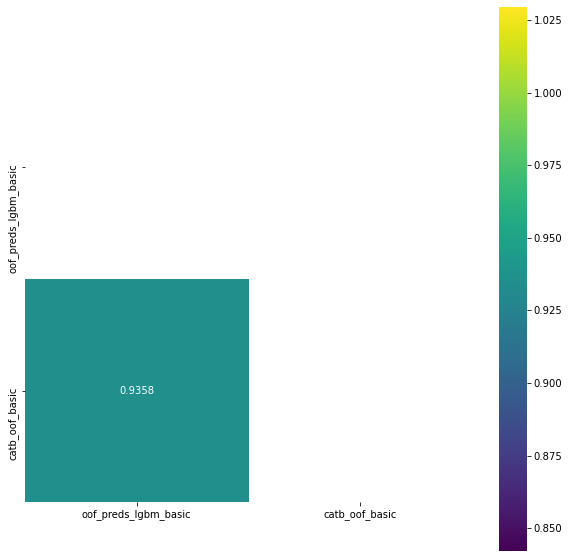

In [108]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [109]:
scores_mean = scores.mean(axis=1)
score = mean_squared_error(target, scores_mean)
print(f"Score = {round(score, 5)}")

Score = 61.47671


In [110]:
scores_mean = gmean(scores, axis=1)
score = mean_squared_error(target, scores_mean)
print(f"Score = {round(score, 5)}")

Score = 61.47638


In [113]:
lgbm_0 = estimators_lgbm_target_1[0].predict(test_freq_encoder[feature_importance])
lgbm_1 = estimators_lgbm_target_1[1].predict(test_freq_encoder[feature_importance])
lgbm_2 = estimators_lgbm_target_1[2].predict(test_freq_encoder[feature_importance])
lgbm_3 = estimators_lgbm_target_1[3].predict(test_freq_encoder[feature_importance])
lgbm_4 = estimators_lgbm_target_1[4].predict(test_freq_encoder[feature_importance])
lgbm_5 = estimators_lgbm_target_1[5].predict(test_freq_encoder[feature_importance])


In [114]:
xgb_basic_0 = xgb_estimators_target_1[0].predict(xgb.DMatrix(test_freq_encoder[feature_importance]))
xgb_basic_1 = xgb_estimators_target_1[1].predict(xgb.DMatrix(test_freq_encoder[feature_importance]))
xgb_basic_2 = xgb_estimators_target_1[2].predict(xgb.DMatrix(test_freq_encoder[feature_importance]))
xgb_basic_3 = xgb_estimators_target_1[3].predict(xgb.DMatrix(test_freq_encoder[feature_importance]))
xgb_basic_4 = xgb_estimators_target_1[4].predict(xgb.DMatrix(test_freq_encoder[feature_importance]))
xgb_basic_5 = xgb_estimators_target_1[5].predict(xgb.DMatrix(test_freq_encoder[feature_importance]))

In [115]:
catb_basic_0 = catb_estimators_target_1[0].predict(test_freq_encoder[feature_importance])
catb_basic_1 = catb_estimators_target_1[1].predict(test_freq_encoder[feature_importance])
catb_basic_2 = catb_estimators_target_1[2].predict(test_freq_encoder[feature_importance])
catb_basic_3 = catb_estimators_target_1[3].predict(test_freq_encoder[feature_importance])
catb_basic_4 = catb_estimators_target_1[4].predict(test_freq_encoder[feature_importance])
catb_basic_5 = catb_estimators_target_1[5].predict(test_freq_encoder[feature_importance])

In [148]:
scores = pd.DataFrame({
    'lgbm_0':lgbm_0,
    'lgbm_1':lgbm_1,
    'lgbm_2':lgbm_2,
    'lgbm_3':lgbm_3,
    'lgbm_4':lgbm_4,
    'lgbm_5':lgbm_5,
    'xgb_basic_0':xgb_basic_0,
    'xgb_basic_1':xgb_basic_1,
    'xgb_basic_2':xgb_basic_2,
    'xgb_basic_3':xgb_basic_3,
    'xgb_basic_4':xgb_basic_4,
    'xgb_basic_5':xgb_basic_5,
    'catb_basic_0':catb_basic_0,
    'catb_basic_1':catb_basic_1,
    'catb_basic_2':catb_basic_2,
    'catb_basic_3':catb_basic_3,
    'catb_basic_4':catb_basic_4,
    'catb_basic_5':catb_basic_5,

    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

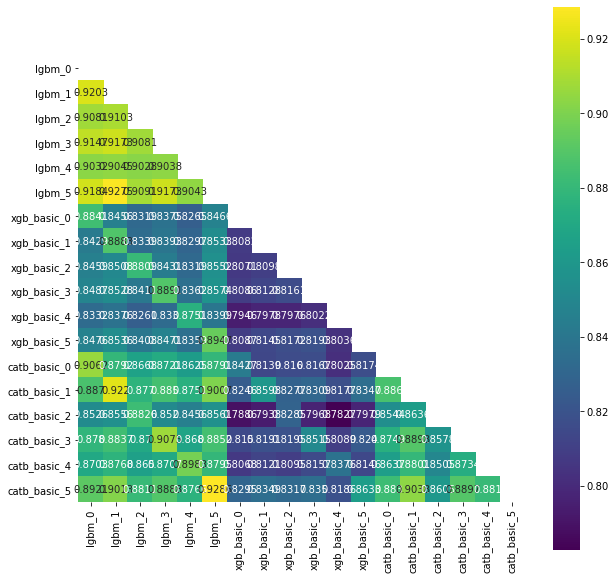

In [149]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [150]:
scores_mean = gmean(scores, axis=1)

In [151]:
preds_final = pd.DataFrame()
preds_final['id']  = test.index.copy()
preds_final['loss'] = scores_mean

In [152]:
preds_final.to_csv('result.csv', index=False)

In [153]:
preds_final

,id,loss
0,250000,7.963338
1,250001,4.482574
2,250002,8.100492
3,250003,7.354006
4,250004,7.375463
...,...,...
149995,399995,7.385007
149996,399996,6.990070
149997,399997,6.062905
149998,399998,5.477704
